# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
import datetime
import os
from skimage.transform import resize 
from cv2 import imread
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Project_data2.zip'

In [ ]:
train_doc = np.random.permutation(open(r"/content/Project_data/train.csv").readlines())
val_doc = np.random.permutation(open(r"/content/Project_data/val.csv").readlines())


In [ ]:
print(train_doc.shape)
print(val_doc.shape)

(663,)
(100,)


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(start = 1, stop = 29, num=18)).astype('int') # Here we are defining that out of 30 how many images/frames we want to consider and we took 18 images
    while True:
        t = np.random.permutation(folder_list)
# As, in the project data there is train.csv and val.csv which contains the data regarding images and arranged in such a order that class 0 is at starting and this goes on consecutively till class 5
# So, these classes are in sequence so this can create bias in the data, so we need to shuffle them to learn robustly and for this we are using "np.random.permutation"

        num_batches = len(t) // batch_size                              # calculate the number of batches
        for batch in range(num_batches):                                # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3))         # 18 is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))                     # batch_labels is the one hot representation of the output
            for folder in range(batch_size):                            # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):                     #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(100,100,3)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =     (image_resized[:, :,0])/255.0               #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =     (image_resized[:, :,1])/255.0               #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =     (image_resized[:, :,2])/255.0               #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        
        remaining_seq = len(t) % batch_size 
        if (remaining_seq!= 0):
            
            batch_data = np.zeros((remaining_seq,18,100,100,3)) # here first we specified the remaining_seq because the remaining sequence or images are not in the multiple of batch_size and because of this
          #  we defined the shape such that no sequence is left over 
            batch_labels = np.zeros((remaining_seq,5))
            for folder in range(remaining_seq):
                # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*remaining_seq)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):                     #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*remaining_seq)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(100,100,3)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =     (image_resized[:, :,0])/255.0               #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =     (image_resized[:, :,1])/255.0               #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =     (image_resized[:, :,2])/255.0               #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*remaining_seq)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
print(curr_dt_time)

train_path = r"/content/Project_data/train"
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

val_path = r"/content/Project_data/val"
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


2023-02-13 10:16:47.459009
# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

# Model - 01 

In [ ]:


num_classes = 5
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same', input_shape=(18,100,100,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides = (2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 100, 100, 16)  1312      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 100, 100, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 50, 50, 32)     13856     
                                                                 
 batch_normalization_5 (Batc  (None, 9, 50, 50, 32)    128       
 hNormalization)                                                 
                                                      

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
batch_size = 64
train_generator = generator(train_path, train_doc[:120], batch_size)
val_generator = generator(val_path, val_doc[:30], batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
num_epochs = 25
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 4.1175 - categorical_accuracy: 0.4307 Source path =  /content/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2023-02-1303_49_13.772526/model-00001-4.11745-0.43072-4.07409-0.23333.h5
11/11 [==============================] - 138s 13s/step - loss: 4.1175 - categorical_accuracy: 0.4307 - val_loss: 4.0741 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 0.8958 - categorical_accuracy: 0.7088 
Epoch 2: saving model to model_init_2023-02-1303_49_13.772526/model-00002-0.89581-0.70884-2.29706-0.33333.h5
11/11 [==============================] - 136s 14s/step - loss: 0.8958 - categorical_accuracy: 0.7088 - val_loss: 2.2971 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.4230 - categorical_accuracy: 0.8313 
Epoch

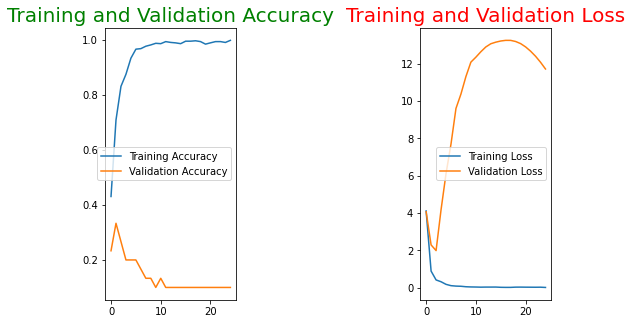

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy',size = 20 , color='g')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss', size = 20 , color='r')
plt.show()

# Model - 02 

## Using activation as 'elu' 

In [ ]:

num_classes = 5
model = Sequential()

model.add(Conv3D(16, kernel_size=(2,2,2), padding='same', input_shape=(18,100,100,3), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=(2,2,2), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(2,2,2), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=(2,2,2), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(256, kernel_size=(2,2,2), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1,1,1), strides=(1,1,1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(num_classes,activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 100, 100, 16)  400       
                                                                 
 batch_normalization_8 (Batc  (None, 18, 100, 100, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 50, 100, 16)   0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 9, 50, 100, 16)    0         
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 50, 100, 32)    4128      
                                                                 
 batch_normalization_9 (Batc  (None, 9, 50, 100, 32)  

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
batch_size = 64
train_generator = generator(train_path, train_doc[:240], batch_size)
val_generator = generator(val_path, val_doc[:30], batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
num_epochs = 25
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.8574 - categorical_accuracy: 0.5134Source path =  /content/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2023-02-1303_49_13.772526/model-00001-1.85743-0.51339-3.03614-0.23333.h5
11/11 [==============================] - 133s 12s/step - loss: 1.8574 - categorical_accuracy: 0.5134 - val_loss: 3.0361 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.0274 - categorical_accuracy: 0.7271 
Epoch 2: saving model to model_init_2023-02-1303_49_13.772526/model-00002-1.02736-0.72713-8.56063-0.16667.h5
11/11 [==============================] - 128s 13s/step - loss: 1.0274 - categorical_accuracy: 0.7271 - val_loss: 8.5606 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.6276 - categorical_accuracy: 0.8293 
Epoch 

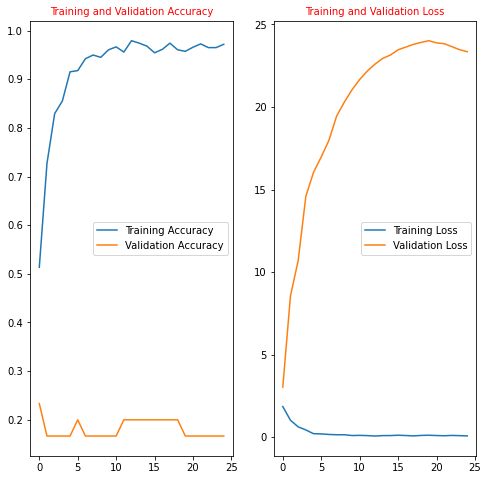

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy', size=10, color='r')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss', size=10, color='r')
plt.show()

# Model - 03

## Let's try CNN + RNN 

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(start = 1, stop = 29, num=20)).astype('int') # Here we are defining that out of 30 how many images/frames we want to consider and we took 18 images
    while True:
        t = np.random.permutation(folder_list)
# As, in the project data there is train.csv and val.csv which contains the data regarding images and arranged in such a order that class 0 is at starting and this goes on consecutively till class 5
# So, these classes are in sequence so this can create bias in the data, so we need to shuffle them to learn robustly and for this we are using "np.random.permutation"

        num_batches = len(t) // batch_size                              # calculate the number of batches
        for batch in range(num_batches):                                # we iterate over the number of batches
            batch_data = np.zeros((batch_size,20,100,100,3))         # 18 is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))                     # batch_labels is the one hot representation of the output
            for folder in range(batch_size):                            # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):                     #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(100,100,3)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =     (image_resized[:, :,0])/255.0               #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =     (image_resized[:, :,1])/255.0               #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =     (image_resized[:, :,2])/255.0               #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        
        remaining_seq = len(t) % batch_size 
        if (remaining_seq!= 0):
            
            batch_data = np.zeros((remaining_seq,20,100,100,3)) # here first we specified the remaining_seq because the remaining sequence or images are not in the multiple of batch_size and because of this
          #  we defined the shape such that no sequence is left over 
            batch_labels = np.zeros((remaining_seq,5))
            
            for folder in range(remaining_seq):
                # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*remaining_seq)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):                     #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*remaining_seq)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(100,100,3)).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =     (image_resized[:, :,0])/255.0               #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =     (image_resized[:, :,1])/255.0               #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =     (image_resized[:, :,2])/255.0               #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*remaining_seq)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [ ]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='elu'),input_shape=(20,100,100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2,2))))
        
model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2,2))))
        
model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2,2))))
        
model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2,2))))
        
model.add(TimeDistributed(Conv2D(256, (2, 2) , padding='same', activation='elu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2,2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(64))
model.add(Dropout(0.5))

model.add(Dense(64,activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  208      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 32)   2080      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)   1

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
batch_size = 64
train_generator = generator(train_path, train_doc[:400], batch_size)
val_generator = generator(val_path, val_doc[:50], batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
num_epochs = 25
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.9887 - categorical_accuracy: 0.2622Source path =  /content/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2023-02-1310_16_47.459009/model-00001-1.98867-0.26220-1.91061-0.26000.h5
11/11 [==============================] - 167s 14s/step - loss: 1.9887 - categorical_accuracy: 0.2622 - val_loss: 1.9106 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.5453 - categorical_accuracy: 0.3947
Epoch 2: saving model to model_init_2023-02-1310_16_47.459009/model-00002-1.54528-0.39474-2.13829-0.22000.h5
11/11 [==============================] - 141s 14s/step - loss: 1.5453 - categorical_accuracy: 0.3947 - val_loss: 2.1383 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 1.3454 - categorical_accuracy: 0.4787 
Epoch 3

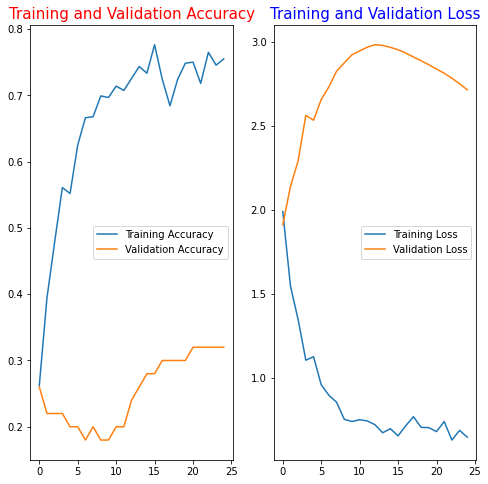

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy', size=15, color='r')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss', size=15, color='b')
plt.show()

# **Model-04**

In [23]:
import imageio

In [24]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32) #cropping the (120X160) image to make (120X120)
                    else:
                        print("")
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction 
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                                        
                batch_labels[folder, int(t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [25]:
#write your model here
Input_shape = (18, 84, 84, 3)

model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,1,1), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,1,1), strides=(1,1,1)))

# Hidden layers

model.add(Flatten())
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [26]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'],run_eagerly=True)
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_5 (Batc  (None, 18, 84, 84, 64)   256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 84, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 84, 64)     110656    
                                                                 
 batch_normalization_6 (Batc  (None, 9, 42, 84, 64)   

In [27]:
batch_size = 32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]
#callbacks_list = [checkpoint]

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6155 - categorical_accuracy: 0.2236Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-02-1310_16_47.459009/model-00001-1.61549-0.22360-1.59889-0.37500.h5
21/21 [==============================] - 92s 4s/step - loss: 1.6155 - categorical_accuracy: 0.2236 - val_loss: 1.5989 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5801 - categorical_accuracy: 0.2774
Epoch 2: saving model to model_init_2023-02-1310_16_47.459009/model-00002-1.58006-0.27743-1.60580-0.18750.h5
21/21 [==============================] - 96s 5s/step - loss: 1.5801 - categorical_accuracy: 0.2774 - val_loss: 1.6058 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.5576 - categorical_accuracy: 0.3188
Epoch 3: sav

model_init_2023-02-1310_16_47.459009/model-00030-0.79598-0.71429-0.49134-0.87500.h5

In [33]:
# used to save the file which contains weights and bias 

model.save('model_init_2023-02-1310_16_47.459009/model-00030-0.79598-0.71429-0.49134-0.87500.h5')

In [34]:
# this function is used to save .h5 file which contains optimisied weights and biases in the local machine 

from google.colab import files
files.download("model_init_2023-02-1310_16_47.459009/model-00030-0.79598-0.71429-0.49134-0.87500.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

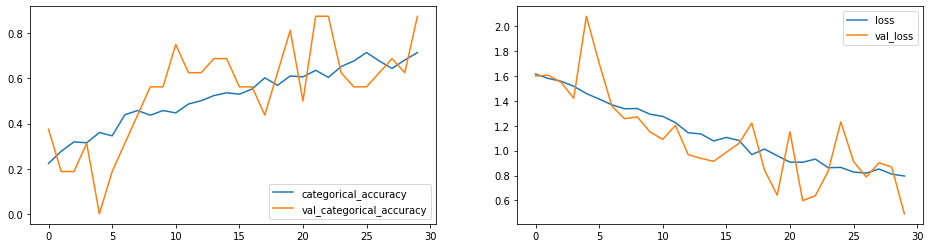

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])   
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])   
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])
plt.show()

# SUMMARY 

- THE LAST MODEL MODEL-04 DID GREAT IN TERMS OF VALIDATION ACCURACY IT HAS GIVEN EXTREMELY WONDERFUL RESULTS WHICH ARE WRITTEN AS :- 


**Training Accuracy :- 71%**

**Validation Accuracy :- 87%**